In [1]:
#@title Test Contexts
TEST_CONTEXTS=[
    # "IMAGES",
    # "DATASET",
    # "DATASET_PROFILE",
    # "ATTENTION_PROFILE",
    # "MODEL_PROFILE",
    # "MODEL_INSTANTIATION"
    # "MODEL_TRAIN"
]

ONLY_ONE_ORGAN = True; ONLY_ORGAN="kidney"

# Tensorboard

In [2]:
###### !pip install -U tensorboard_plugin_profile
# %reload_ext tensorboard
# %tensorboard --logdir /tmp/tensorboard/logs

# Initialize Environment

## Pip Installs and Kaggle Downloads

In [3]:
# !pip install -U tensorboard-plugin-profile kaggle tensorflow_io==0.24.0
# from google.colab import files

# uploaded = files.upload()
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c hubmap-organ-segmentation
# !unzip /content/hubmap-organ-segmentation.zip

In [4]:
# !pip show tensorflow-estimator tensorboard tensorflow tensorflow_io

## Initialize Imports

In [5]:
%matplotlib inline

import datetime

# Definition Modules
from abc import ABC, abstractmethod
from typing import Union, Optional

# Operation Modules
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.python.types.core import TensorLike
from keras.layers.dense_attention import BaseDenseAttention

import math
from collections import OrderedDict
from collections.abc import Mapping
from itertools import chain

# Early Visualization Imports
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('dark_background')

# Fix RLE over-length error for CSV processing
import csv
import sys
csv.field_size_limit(sys.maxsize)

131072

# Quality-of-Life Functions

In [6]:
def smart_repr(key, value):
    if isinstance(value, tf.Tensor) and tf.size(value) <= 10:
      print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
    elif isinstance(value, OrderedDict):
      for dk, dv in value.items():
        smart_repr(f"{key}[{dk}]", dv)
    else:
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")

def simple_sample(ds, reply=False):
  for batch in ds.take(1):
    for key, value in batch.items():
      smart_repr(key, value)
    if reply:
      return batch

In [7]:
#@title ChannelDict
from typing import Callable, Tuple, Dict, List, Set, Iterable

def _channel_shape(tensor:TensorLike) -> Tuple:
    if isinstance(tensor, tf.RaggedTensor):
        raise NotImplementedError("ChannelDict support for RaggedTensor is deprecated.")
        # if tensor.ragged_rank != 2:
        #     raise ValueError(f"ChannelDict cannot handle tf.RaggedTensor without ragged_rank==2 (ragged width and height). Had rank {tensor.ragged_rank} and shape {tensor.shape}")
        # ragged_dim1, repeated_ragged_dim2 = tensor.nested_row_lengths()
        # # print("Channel Shape ragged_dim1 repeated_ragged_dim2:", ragged_dim1, repeated_ragged_dim2)
        # second_dim_indices = tf.scan(lambda sum, update: sum+update, ragged_dim1, initializer=tf.cast(-1, tf.int64))
        # ragged_dim2 = tf.gather(repeated_ragged_dim2, second_dim_indices)
        # ragged_dims = [ragged_dim1, ragged_dim2]

        # return tuple([
        #     tuple(ragged_dims.pop(0).numpy())
        #     if ragged_dim is None else ragged_dim
        #     for ragged_dim in tensor.shape[:-1]
        # ])
    else:
        return tuple(tensor.shape[:-1])

def _pack(to_pack:Iterable[TensorLike]) -> TensorLike:
    return tf.concat(list(to_pack), axis=-1)

class ChannelDict(OrderedDict):
    def shapes(self) -> Tuple[Dict[tuple, Set[str]], int]:
        total_channels=0

        shapes = OrderedDict()
        for k, t in self.items():
            shapes.setdefault(_channel_shape(t), set()).add(k)
            total_channels += t.shape[-1]
        return shapes, total_channels

    def keychannels(self) -> 'OrderedDict[str, int]':
        return OrderedDict([(key, value.shape[-1]) for key, value in self.items()])

    def repack(self) -> 'Tuple[TensorLike, OrderedDict[str, int]]':
        repacked = _pack(self.values())
        return repacked, self.keychannels()

    def packapply(self, fn:Callable[[TensorLike], TensorLike], keyfn:'Callable[[OrderedDict[str, int], OrderedDict[str,int]]]'=lambda x: x, *args, **kwargs) -> 'ChannelDict[str, TensorLike]':
        repacked, keychannel_dict = self.repack()
        result = fn(repacked, *args, **kwargs)
        keychannel_updated = keyfn(keychannel_dict)
        return ChannelDict.resplit(result, keychannel_updated)
    
    def subset(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> 'ChannelDict':
        if ordered_keys is None and unordered_keys is None:
            raise ValueError("ChannelDict subset was given no keys to subset.")
        
        if ordered_keys is not None and unordered_keys is not None:
            raise ValueError("ChannelDict subset was given both ordered and unordered keys to subset - must only have one.")
        
        if ordered_keys is not None:
            return ChannelDict(**{key: self[key] for key in ordered_keys if key in self})
            # return _pack([self[key] for key in ordered_keys if key in self])
        else:
            return ChannelDict(**{key: self[key] for key in self.keys() if ((key in unordered_keys) != invert)})
            # return _pack([value for key, value in self.items() if key in unordered_keys])

    def partialpack(self, ordered_keys:List[str]=None, unordered_keys:Set[str]=None, invert=False) -> TensorLike:
        if ordered_keys is None and unordered_keys is None:
            raise ValueError("ChannelDict partialpack was given no keys to pack.")
        
        if ordered_keys is not None and unordered_keys is not None:
            raise ValueError("ChannelDict partialpack was given both ordered and unordered keys to pack - must only have one.")
        
        if ordered_keys is not None:
            return _pack([self[key] for key in ordered_keys if key in self])
        else:
            return _pack([value for key, value in self.items() if ((key in unordered_keys) != invert)])

    def unbatch(self, axis=0):
        batch_tensor, keychannels = self.repack()
        return [ChannelDict.resplit(tensor, keychannels) for tensor in tf.unstack(batch_tensor, axis=axis)]

    @staticmethod
    def resplit(packed_tensor:TensorLike, keys_channels:'OrderedDict[str, int]') -> 'ChannelDict[str, TensorLike]':
        split = ChannelDict()
        channel_idx = 0
        for key, channel_w in keys_channels.items():
            split[key] = packed_tensor[..., channel_idx:channel_idx+channel_w]
            channel_idx += channel_w
        return split
    
    ## @staticmethod
    # def stack(elements:'List[ChannelDict[str, TensorLike]]') -> 'ChannelDict[str, TensorLike]':
    #     tensors = []
    #     unique_keychannels = set()
    #     unique_dims = set()
    #     for elem in elements:
    #         tensor, keychannels = elem.repack()
    #         unique_keychannels.add(str(keychannels))
    #         tensors.append(tensor)

    #         shape, _ = elem.shapes()
    #         unique_dims.add(next(iter(shape.keys())))

    #     if len(unique_keychannels) != 1:
    #         raise NotImplementedError("ChannelDict.stack got ChannelDicts with non-identical keychannels.")

    #     if len(unique_dims) == 1:
    #         stacked = tf.stack(tensors)
    #     else:
    #         stacked = tf.ragged.stack(tensors)

    #     # We snuck 'keychannels' into locals when we defined it in the first for-loop.
    #     return ChannelDict.resplit(stacked, keychannels)

# def batch(dataset:tf.data.Dataset, *args, **kwargs) -> 'tf.data.Dataset':
#     element_spec=dataset.element_spec
#     keychannels = element_spec.keychannels()
    
#     batched_packed_dataset = dataset.map(lambda cd: tf.RaggedTensor.from_tensor(cd.repack()[0])).batch(*args, **kwargs)
#     batched_resplit_dataset= batched_packed_dataset.map(lambda tensor: ChannelDict.resplit(tensor, keychannels))

#     return batched_resplit_dataset

def split_data_to_x_y(data:'ChannelDict[str, TensorLike]') -> 'Tuple[ChannelDict[str, TensorLike], TensorLike]':
    return data.subset(unordered_keys={"target"}, invert=True), data["target"]

In [8]:
def imshow_c(im):
    if isinstance(im, tf.RaggedTensor):
        im = im.to_tensor(0)
    imc = im.shape[-1]
    if imc == 1:
        plt.imshow(im[..., 0])
    elif imc <= 3:
        plt.imshow(tf.pad(im, [(0, 0), (0, 0), (0, 3-imc)]))
    elif imc == 4:
        plt.imshow(im)
    elif len(im.shape) == 2:
        plt.imshow(im)
    else:
        raise NotImplementedError("imshow_c can't show more-than-4-channel images")

# Dataset Pipeline

## Dataset Hyperparameters

In [9]:
organs = {b'spleen', b'kidney', b'largeintestine', b'prostate', b'lung'}
onehot_key="organ"

### If you wanted to generate the organs list:
# organs = set()
# for i, entry in enumerate(root_dataset):
#   entry_organ = entry["organ"].numpy()
#   organs.add(entry_organ)
#   if i%100 == 0:
#     print(f"Step {i} Complete")
# print(organs)

## Image and Metadata Origination

### Dataset and ChannelDict Transformations

In [10]:
def extract_paths(d):
    d["img_w_h"] = tf.stack([d["img_width"], d["img_height"]], axis=-1, name="stack_width_height.stack_width_height")
    d.pop("img_width")
    d.pop("img_height")

    d["fpath"] = tf.strings.join(["/content/train_images/", tf.strings.as_string(d["id"]), ".tiff"])
    return d

In [11]:
@tf.autograph.experimental.do_not_convert
def decode_tiff(*args, **kwargs):
    return tfio.experimental.image.decode_tiff(*args, **kwargs)

@tf.function
def extract_load_image(image_fpath, authoritative_dimensions):
    image = tf.io.read_file(image_fpath, name="extract_load_image.io_read_file")

    # I promise it's OK to discard the alpha channel of the data we're using
    image = decode_tiff(image, name="extract_load_image.decode_tiff")[:, :, :3]

    # Normalize and convert to float##
    image = tf.cast(image, tf.float32)/255.0
    
    # print("imd:", image)
    # image.set_shape(authoritative_dimensions.numpy())
    tf.reshape(image, authoritative_dimensions)
    # print("imds:", image)
    return image


@tf.function
def rle_decode_tf(mask_rle, shape):
    # shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    # ones = tf.ones([total_ones], tf.uint8)
    ones = tf.ones([total_ones], tf.float32)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    # Reshape into mask
    return tf.transpose(tf.reshape(mask_flat, shape))

In [12]:
@tf.function
def load_construct_spatial_data(k):
    img_target_shape = tf.concat([k["img_w_h"], [3]], axis=-1)
    image = extract_load_image(k["fpath"], img_target_shape)
    image = tf.reshape(image[..., :3], img_target_shape)
    seg   = rle_decode_tf(k["rle"], k["img_w_h"])

    constructed = ChannelDict(target=seg[..., None], source=image[..., :3])

    # constructed = tf.concat([tf.expand_dims(seg, axis=-1), image[:, :, :3]], axis=-1, name="load_constructed_spatial_data.concat_constructed")
    # constructed = tf.reshape(constructed, tf.concat([k["img_w_h"], [4]], -1))
    return constructed


#?? @tf.function
def load_construct_spatial_data_from_dataset(d):
    d["spatial_data"] = load_construct_spatial_data(d)
    return d

In [13]:
desired_params = {"organ", "pixel_size", "img_w_h", "spatial_data"}

def drop_spare_params(d, desired_params=desired_params):
    keys = iter(list(d.keys()))
    for key in keys:
        if key not in desired_params:
            d.pop(key)
    return d

In [14]:
ptim_ds_cache = "/tmp/ptim_ds_cache/cache"
def make_pretransformed_images_dataset(csv_path="/content/train.csv"):
    root_dataset = tf.data.experimental.make_csv_dataset("/content/train.csv", batch_size=1, num_epochs=1).unbatch()
    if ONLY_ONE_ORGAN:
        root_dataset = root_dataset.filter(lambda d: d["organ"] == ONLY_ORGAN)
    paths_dataset = root_dataset.map(extract_paths, name="Extract_Image_Paths")
    pretransformed_images_dataset_plus_params = paths_dataset.map(load_construct_spatial_data_from_dataset)#.prefetch?
    pretransformed_images_dataset = pretransformed_images_dataset_plus_params.map(drop_spare_params)
    return pretransformed_images_dataset

### Image Origination Testing

Expected ElementSpec:
```
OrderedDict([  
    ('organ', TensorSpec(shape=(), dtype=tf.string, name=None)),   
    ('pixel_size', TensorSpec(shape=(), dtype=tf.float32, name=None)),   
    ('img_w_h', TensorSpec(shape=(2,), dtype=tf.int32, name=None)),   
    ('spatial_data', ChannelDict([  
            ('target', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)),   
            ('source', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))  
    ]))
])
```



In [15]:
if "IMAGES" in TEST_CONTEXTS:
    ptim_ds_test = make_pretransformed_images_dataset()
    print(ptim_ds_test.element_spec)

## Spatial Information Construction

In [16]:
#@title Dataset Hyperparameters

TARGET_CHANNELS = 1
SRC_IM_CHANNELS = 3
CATEGORY_1HOT_D = len(organs)


########## Embedding spatial information ##########
EMBED_UM_PER_PX = False
NUM_UM_PER_PX_C = 1 if EMBED_UM_PER_PX else 0

USE_ORIGINAL_XY = False
ORIGINAL_XY_CHN = 2 if USE_ORIGINAL_XY else 0

SINE_ANNOTATION = False and USE_ORIGINAL_XY
SIN_FREQUENCIES = [0.1, 1, 10]
SINE_ANNOTATE_N = 2*len(SIN_FREQUENCIES) if SINE_ANNOTATION else 0

USE_CENTER_DIST = False and USE_ORIGINAL_XY
CENTER_DIST_CHN = 1 if USE_CENTER_DIST else 0

########## Annotation Summary ##########
# The annotated image dims will be:
# [width, height, ORIGINAL_XY_CHN + TARGET_CHANNELS + SRC_IM_CHANNELS + CATEGORY_1HOT_D + SINE_ANNOTATE_N + CENTER_DIST_CHN]
SOURCE_CHANNELS = SRC_IM_CHANNELS + CATEGORY_1HOT_D + NUM_UM_PER_PX_C + SINE_ANNOTATE_N + CENTER_DIST_CHN # Channels which will be fed as the source data to the model
PREPRO_CHANNELS = ORIGINAL_XY_CHN + TARGET_CHANNELS + SOURCE_CHANNELS                   # Total channels coming off the annotation pipeline

########## Delivery Parameters ##########
DATASET_BATCH_N = 1 # Non-1 batches are not implemented
PREPRO_DOWNSIZE = 1

### Construct fullsize image spatial data

In [17]:
@tf.function
def compute_original_coordinates(img_w_h, pixel_size):
  um_wh_2 = (tf.cast(img_w_h, tf.float32)*tf.expand_dims(pixel_size, axis=-1))/2.0
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], img_w_h[0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], img_w_h[1])
  XY = tf.stack(tf.meshgrid(h_ruler, v_ruler), axis=-1)

  return XY

In [18]:
@tf.function
def compute_center_distance(XY):
  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  return DistFromCenter

@tf.function
def compute_sine_rulers(XY, sin_frequencies=SIN_FREQUENCIES):
  return tf.concat([0.5 + 0.5*tf.math.sin(XY * math.pi * 2 * freq) for freq in sin_frequencies], axis=-1)

In [19]:
def tile_vector_to_size(vector, size):
    tiled = tf.tile(tf.reshape(vector, [1, 1, -1]), tf.concat([size[..., ::-1], [1]], axis=-1))
    if hasattr(vector, "shape") and len(vector.shape):
        print(f"Vector {vector} has shape {vector.shape}")
        return tf.ensure_shape(tiled, [None, None, vector.shape[-1]])
    else:
        return tf.ensure_shape(tiled, [None, None, 1])

In [20]:
# @tf.function # I wish this would work as a tf.function, but somehow it can't find an object's __repr__, so I'm leaving it this way.
def compute_onehots(input, multiples, categories=organs):
    onehot = tf.cast(tf.stack([tf.equal(input, s) for s in categories], axis=-1), dtype=tf.float32)
    onehot = tile_vector_to_size(onehot, multiples)
    return onehot

In [21]:
@tf.function
def resize_spatial_data(spatial_data, img_w_h, prepro_downsize=PREPRO_DOWNSIZE, **kwargs):
  output_shapes = tf.cast(
    tf.cast(img_w_h, tf.float32) * prepro_downsize,
    tf.int32
  )
  return tf.image.resize(spatial_data, output_shapes, preserve_aspect_ratio=True)

In [22]:
def build_spatial_data(d, onehot_key=onehot_key, embed_um_per_px=EMBED_UM_PER_PX, use_original_xy=USE_ORIGINAL_XY, use_center_dist=USE_CENTER_DIST, sine_annotation=SINE_ANNOTATION):
    ######### Embed Data
    spatial_d = d["spatial_data"]

    img_w_h    = d["img_w_h"]
    pixel_size = d["pixel_size"]
    onehot     = d[onehot_key]

    spatial_d[onehot_key] = compute_onehots(onehot, img_w_h)
    print("Organs Shape:", spatial_d[onehot_key].shape)


    if embed_um_per_px:
        spatial_d["pixel_size"] = tile_vector_to_size(pixel_size, img_w_h)
        print("PX Size Shape:", spatial_d["pixel_size"].shape)

    if use_original_xy:
        XY = compute_original_coordinates(img_w_h, pixel_size)
        spatial_d["XY"] = XY
        if use_center_dist:
            spatial_d["center_dist"] = compute_center_distance(XY)
        if sine_annotation:
            spatial_d["sine_annotation"] = compute_sine_rulers(XY)
  
    ########## Do Resizing
    if PREPRO_DOWNSIZE != 1:
        spatial_d = spatial_d.packapply(lambda t: resize_spatial_data(t, img_w_h))
    # return spatial_d
    return d

In [23]:
# construct_spatial_dataset = lambda: make_pretransformed_images_dataset().map(build_spatial_data, name="Build_Spatial_Data").batch(1)

# We cache slightly more metadata than we need so that we can make decisions with it later

CSD_Cache_Path = "/tmp/humbap_spatial_data_cache"
pre_augmented_images = lambda: make_pretransformed_images_dataset() \
                                        .map(build_spatial_data, name="Build_Spatial_Data", num_parallel_calls=tf.data.AUTOTUNE) \
                                        .map(lambda e: e["spatial_data"]) \
                                        .batch(1) \
                                        .repeat()

### Data Augmentation

In [24]:
def augment_spatial_data(d, **kwargs):
    augmentation = tf.keras.Sequential([
        # tf.keras.layers.RandomRotate
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomZoom((0, -0.2)),
    ])

    return ChannelDict(d).packapply(lambda x: augmentation(x, **kwargs))

In [25]:
augmented_images = lambda: pre_augmented_images().map(augment_spatial_data)

## Expose common dataset function

In [26]:
# construct_spatial_dataset = lambda: augmented_images().prefetch(tf.data.AUTOTUNE)
construct_spatial_dataset = lambda: pre_augmented_images().prefetch(tf.data.AUTOTUNE)

## Pipeline Test

In [27]:
if "DATASET" in TEST_CONTEXTS:
    dataset = construct_spatial_dataset()
    print("Dataset Spec:", dataset.element_spec)
    ds_sample = ChannelDict(next(iter(dataset)))
    print("Dataset Shapes:", ds_sample.shapes())
    st_pack = ds_sample.partialpack(ordered_keys=["source", "target"])
    print(st_pack.shape)
    imshow_c(st_pack[0])
    # st_pack_m = st_pack.merge_dims(0, 1)
    # imshow_c(st_pack_m)



---

# Model Definition

In [67]:
#@title Model Hyperparameters
# conv2d_stride_sample_sizes = [
#     (32, 3, None),
#     # (32, 3, None),
#     # (32, 3, None),
#     # (32, 3, None),
#     (None, None, 3),
#     (64, 3, None),
#     (None, None, 3),
#     (64, 5, None)
# ]

conv2d_stride_sample_sizes = [
    (8, 3, None),
    (8, 3, None),
    (None, None, 3),
    (16, 3, None),
    (None, None, 3),
    (16, 3, None)
]

# vertex_attention = [None]
vertex_attention = [None]

## Model Classes

In [68]:
class PadCombine(tf.keras.layers.Layer):
    def call(self, inputs, *args, **kwargs):
        return tf.concat([pad_like(*inputs), inputs[1]], axis=-1)

@tf.function
def pad_like(to_pad, to_shape):
    diff = tf.subtract(tf.shape(to_shape)[1:-1], tf.shape(to_pad)[1:-1])
    diff_half = tf.cast(diff, tf.float32)/2.0
    diff_floor_half = tf.cast(tf.math.floor(diff_half), tf.int32)
    diff_ceil_half  = tf.cast(tf.math.ceil( diff_half), tf.int32)

    return tf.pad(to_pad, [(0, 0), (diff_floor_half[0], diff_ceil_half[0]), (diff_floor_half[1], diff_ceil_half[1]), (0, 0)])

# def assemble(source, c2d_stride_sample_list):
#     if len(c2d_stride_sample_list):
#         c2d, stride, sample = c2d_stride_sample_list[0]

#         compress_step = source
#         if c2d is not None and stride is not None:
#             # We're constructing a Conv2D layer
#             compress_step = tf.keras.layers.Conv2D(c2d, stride, activation="relu")(source)
#         elif sample is not None:
#             compress_step = tf.keras.layers.MaxPool2D(sample)(source)
#         else:
#             raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
#         expand_step, compress_list, expand_list = assemble(compress_step, c2d_stride_sample_list[1:])
        
#         if len(compress_list):
#             expand_step = PadCombine()([expand_step, compress_step])

#         if c2d is not None and stride is not None:
#             expand_step = tf.keras.layers.Conv2DTranspose(c2d, stride, activation="relu")(expand_step)
#         elif sample is not None:
#             expand_step = tf.keras.layers.UpSampling2D(sample)(expand_step)
#         else:
#             raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
#         compress_list.insert(0, compress_step)
#         expand_list.append(expand_step)

#         return expand_step, compress_list, expand_list
#     else:
#         return source, [], [source]

# def build_e2e_model(model_depth_specs=conv2d_stride_sample_sizes, return_compression_model=False):
#     Source = tf.keras.Input(shape=(None, None, SOURCE_CHANNELS), name="source")
#     Target = tf.keras.Input(shape=(None, None, TARGET_CHANNELS), name="target")

#     expanded, compression_list, expansion_list = assemble(Source, model_depth_specs)
#     estimated = tf.keras.layers.Conv2D(1, 1, padding='same')(expanded)

#     compression_model = tf.keras.Model(Source, compression_list[-1], name="compression")
#     e2e_model = tf.keras.Model(Source, estimated)
#     if return_compression_model:
#         return e2e_model, compression_model
#     else:
#         return e2e_model



In [69]:
class LocalPatches(tf.keras.layers.Layer):
    def __init__(self, window_size=3, **kwargs):
        super().__init__()
        self.window_size=window_size
        self.window_area=window_size**2
        ws = self.window_size
        wa = self.window_area
        indices = tf.reshape(tf.repeat(tf.range(wa), 2), (-1, 2))
        self.patch_kernel = tf.reshape(tf.scatter_nd(indices, tf.ones(wa), [wa, wa]), [ws,ws,wa], name="Context_Kernel")
        self.dc2d_kwargs = kwargs
    
    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.channel_kernel = tf.repeat(self.patch_kernel[:, :, None, :], input_channels, axis=2)

    def call(self, source):
        flattened_local = tf.nn.depthwise_conv2d(source, self.channel_kernel, [1, 1, 1, 1], 'SAME', **self.dc2d_kwargs)

        src_shape = tf.shape(source)
        unchanneled_local = tf.reshape(flattened_local, [src_shape[0], src_shape[1], src_shape[2], src_shape[3], self.window_area])
        channeled_local = tf.transpose(unchanneled_local, [0, 1, 2, 4, 3])
        return channeled_local

In [70]:
# input_shape = [2, 7, 7, 6]
# flat_input = tf.range(tf.math.reduce_prod(input_shape), dtype=tf.float32)
# input = tf.reshape(flat_input, input_shape)

# xp = tf.image.extract_patches(images=input, sizes=[1, 3, 3, 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding="SAME")
# xr = tf.reshape(xp, [input_shape[0], input_shape[1], input_shape[2], -1, input_shape[3]])
# # xt = tf.transpose(xr, [0, 1, 2, 4, 3])
# xt = xr
# lp = LocalPatches(window_size=3)(input)

# print(input[0, 0, 0, 0])
# print(input[0, :, :, 0])
# print("")
# print(xp[0, 0, 0])
# print(xr[0, 0, 0])
# print("")
# print(xt[0, 0, 0, :, 0])
# print(lp[0, 0, 0, :, 0])

In [71]:
class WindowedAttention(tf.keras.layers.Layer):
    def __init__(self, attending_radius=1):
        super().__init__()
        self.attending_radius = 1 if attending_radius is None else attending_radius
        self.attending_diameter = self.attending_radius*2 + 1
        self.half_local = (self.attending_diameter+1)*self.attending_radius
        self.patcher = LocalPatches(window_size = self.attending_diameter)

    def build(self, input_shape):
        print(f"{self.__class__.__name__}.build w/ input_shape {input_shape}")
        self.query_layer = tf.keras.layers.Conv2D(input_shape[-1], 3, padding="same", activation='leaky_relu')
    
    @tf.function
    def call(self, source):
        queries = self.query_layer(source)[..., None, :]
        # ------
        
        # pixels_and_neighbors = tf.image.extract_patches(images =source,
        #                                                 sizes  =[1, self.attending_diameter, self.attending_diameter, 1],
        #                                                 strides=[1,1,1,1],
        #                                                 rates  =[1,1,1,1],
        #                                                 padding="SAME")
        # keys = tf.reshape(pixels_and_neighbors, shape=[tf.shape(source)[0], tf.shape(source)[1], tf.shape(source)[2], self.attending_diameter**2, tf.shape(source)[3]], name="WA_Reshape")

        # ------
        # This is faster by a significant margin
        keys = self.patcher(source)
        # ------
        print(f"{self.__class__.__name__}.call q/k: ", queries.shape, keys.shape)
        fluffed_attended = tf.keras.layers.Attention()([queries, keys])
        attended = fluffed_attended[..., 0, :]
        return attended

In [72]:
if "ATTENTION_PROFILE" in TEST_CONTEXTS:
    try:
        import datetime
        stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        logdir = "/tmp/tensorboard/logs/model_test/%s" % stamp
        print(f"Writing to '{logdir}'")
        writer = tf.summary.create_file_writer(logdir)
        tf.summary.trace_on(graph=True)
        tf.profiler.experimental.start(logdir)

        
        src = tf.zeros((1, 200, 200, SOURCE_CHANNELS))
        WindowedAttention()(src)

        with writer.as_default():
            tf.summary.trace_export(
                "WindowedAttention-Extractor on Zeros",
                profiler_outdir=logdir,
                step=0
            )
        
        tf.summary.trace_off()
        tf.profiler.experimental.stop()

    finally:
        try:
            del e2e
        except:
            pass
        try:
            del c
        except:
            pass

In [73]:
def assemble_v2(source, c2d_stride_sample_list):
    if len(c2d_stride_sample_list):
        c2d, stride, sample = c2d_stride_sample_list[0]

        compress_step = source
        if c2d is not None and stride is not None:
            # We're constructing a Conv2D layer
            compress_step = tf.keras.layers.Conv2D(c2d, stride, activation="leaky_relu")(source)
        elif sample is not None:
            # compress_step = tf.keras.layers.MaxPool2D(sample)(source)
            compress_step = tf.keras.layers.AveragePooling2D(sample)(source)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        expand_step, compress_list, expand_list = assemble_v2(compress_step, c2d_stride_sample_list[1:])
        
        if len(compress_list):
            expand_step = PadCombine()([expand_step, compress_step])

        if c2d is not None and stride is not None:
            expand_step = tf.keras.layers.Conv2DTranspose(c2d, stride, activation="leaky_relu")(expand_step)
        elif sample is not None:
            expand_step = tf.keras.layers.UpSampling2D(sample)(expand_step)
        else:
            raise ValueError("Assemble requires either Conv2D or pooling/expansion steps")
        
        compress_list.insert(0, compress_step)
        expand_list.append(expand_step)

        return expand_step, compress_list, expand_list
    else:
        # This is the 'vertex' of the model
        att = [source]
        for radius in vertex_attention:
            att.append(WindowedAttention(attending_radius=radius)(att[-1]))
        return att[-1], [], att
        # attended1 = WindowedAttention(attending_radius=5)(source)
        # return attended1, [], [source, attended1]
        # attended2 = WindowedAttention()(attended1)
        # return attended2, [], [source, attended1, attended2]

def build_e2e_model_v2(model_depth_specs=conv2d_stride_sample_sizes, return_compression_model=False):
    Source = tf.keras.Input(shape=(None, None, SOURCE_CHANNELS), name="source")
    Target = tf.keras.Input(shape=(None, None, TARGET_CHANNELS), name="target")

    expanded, compression_list, expansion_list = assemble_v2(Source, model_depth_specs)
    estimated = tf.keras.layers.Conv2D(1, 1, padding='same')(expanded)

    compression_model = tf.keras.Model(Source, compression_list[-1], name="compression")
    e2e_model = tf.keras.Model(Source, estimated)
    if return_compression_model:
        return e2e_model, compression_model
    else:
        return e2e_model

# Expose the model for testing

In [74]:
ActiveModelClass = build_e2e_model_v2

## Model Build Tests

# Profiling

In [36]:
#@title Model Build Tests
if "MODEL_PROFILE" in TEST_CONTEXTS:
    try:
        import datetime
        stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        logdir = "/tmp/tensorboard/logs/model_test/%s" % stamp
        print(f"Writing to '{logdir}'")
        writer = tf.summary.create_file_writer(logdir)
        tf.summary.trace_on(graph=True)
        tf.profiler.experimental.start(logdir)

        e2e, c = ActiveModelClass(return_compression_model=True)
        src = tf.zeros((1, 200, 200, SOURCE_CHANNELS))
        e2e_on_zeros = e2e(src)

        with writer.as_default():
            tf.summary.trace_export(
                "E2E on Zeros",
                profiler_outdir=logdir,
                step=0
            )
        
        tf.summary.trace_off()
        tf.profiler.experimental.stop()

        c.summary(line_length=150)
        print("\n\n")
        e2e.summary(line_length=150)
        

        
        # tgt = tf.zeros((1, 200, 200, TARGET_CHANNELS))
        print("Compressed Shape:  ", c(src).shape)
        print("Decompressed Shape:", e2e_on_zeros.shape)
        display(tf.keras.utils.plot_model(e2e, show_shapes=True, expand_nested=True))
    finally:
        try:
            del e2e
        except:
            pass
        try:
            del c
        except:
            pass



---


# Construct the Visualization Pipeline

In [37]:
# Visualization Tools
# from PIL import Image
from IPython.display import clear_output, display
# import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
# import datetime

In [38]:
if "ca_metrics" not in locals():
    ca_metrics = {}

In [39]:
hstack_np = lambda k: np.hstack(k.numpy())
vstack_np = lambda k: np.vstack(k.numpy())

hstack_tf = lambda k: tf.concat(tf.unstack(k), axis=1)
vstack_tf = lambda k: tf.concat(tf.unstack(k), axis=0)

def assign_autoscale_colorbar(fig, ax, im):
    ax.autoscale(enable=True, tight=True)
    fig.colorbar(im, ax=ax, shrink=0.5)

def update_axis_data(ax, data):
    im = ax.get_images()[0]
    im.set_data(data)
    im.autoscale()
    im.set_extent([0, data.shape[1], 0, data.shape[0]])

def visualizer(model_name):
    source_axes = None
    model_axes = None
    mse_axes = None
    stack = None
    # if orientation != "v" and (orientation=="h" or batch_size <= 4):
        # Batches span rows (orientation 'h' for 'batch horizontally')
        # mfig, maxes = plt.subplots(nrows=batch_size, ncols=3, sharey='row', figsize=(20, 5), squeeze=False, gridspec_kw={"width_ratios":[3, 1, 1], "height_ratios":[1]})
    mfig, maxes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), squeeze=False, gridspec_kw={"width_ratios": [1, 2, 1, 1]})
    source_ax, y_ax, mse_ax, corr_l_ax = maxes[0]
    corr_r_ax = corr_l_ax.twinx()
    # model_multi = lambda t: tf.concat(tf.unstack(t, axis=-1), axis=2)
    # else:
    #     # Batches span cols (orientation 'v' for 'batch vertically')
    #     # mfig, maxes = plt.subplots(nrows=3, ncols=batch_size, sharex="col", figsize=(20, 5), squeeze=False, gridspec_kw={"height_ratios":[1, 3, 1], "width_ratios":[1]})
    #     mfig, maxes = plt.subplots(nrows=4, ncols=batch_size, figsize=(20, 5), squeeze=False, gridspec_kw={"height_ratios":[1, 3, 1], "width_ratios":[1]})
    #     source_axes = maxes[0, :]
    #     model_axes = maxes[1, :]
    #     mse_axes = maxes[2, :]
    #     corr_l_axes = maxes[3, :]
    #     stack = vstack_tf
    #     model_multi = lambda t: tf.concat(tf.unstack(t, axis=-1), axis=1)
    assign_autoscale_colorbar(mfig, source_ax, source_ax.imshow([[0, 0, 0]], aspect='equal'))
    assign_autoscale_colorbar(mfig, y_ax,           y_ax.imshow([[0]],       aspect='equal', cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0)))
    assign_autoscale_colorbar(mfig, mse_ax,       mse_ax.imshow([[0]],       aspect='equal', cmap="RdBu_r"))
    
    
    # corr_r_ax gets drawn on top, so it carries all the color annotation.
    corr_r_ax.spines["left"].set_color("blue")
    corr_r_ax.spines["right"].set_color("yellow")

    batch = yield
    while True:
        source = batch["source"][0]
        y_data = tf.concat([batch["target"], batch["yhat"]], axis=2)[0, ..., 0]
        
        update_axis_data(source_ax, source)
        update_axis_data(y_ax, y_data)
        update_axis_data(mse_ax, batch["cell_mse"][0, ..., 0])

        y_ = tf.reshape(batch["target"], [-1])
        yh_ =tf.reshape(batch["yhat"]  , [-1])

        corr_l_ax.cla()
        corr_r_ax.cla()
        _, bins, _ = corr_l_ax.hist(tf.boolean_mask(yh_, y_), bins=50, alpha=0.5, color="blue")
        corr_r_ax.hist(tf.boolean_mask(yh_, 1-y_), bins=bins, alpha=0.5, color="yellow")

        batch = yield mfig

In [40]:
class appenDict(dict):
  def update(self, other=None, **kwargs):
    if other is not None:
      for k, v in other.items() if isinstance(other, Mapping) else other:
        if isinstance(v, tf.Tensor):
          prior = self.setdefault(k, tf.zeros((0)))
          self[k] = tf.concat([prior, v[None]], axis=-1)
        else:
          self[k] = v
    for k, v in kwargs:
      if isinstance(v, tf.Tensor):
        prior = self.setdefault(k, tf.zeros((0)))
        self[k] = tf.concat([prior, v[None]], axis=-1)
      else:
        self[k] = v

# Final Instantiation

## Dataset Instantiation

In [41]:
padded_dataset = construct_spatial_dataset()

Vector Tensor("Cast:0", shape=(5,), dtype=float32) has shape (5,)
Organs Shape: (None, None, 5)


In [42]:
data_iter = iter(padded_dataset)

## Model Instantiation

In [75]:
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "/tmp/tensorboard/logs/training/%s" % stamp
print(f"Writing to '{logdir}'")

writer = tf.summary.create_file_writer(logdir)

lr = 2e-2
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
optimizer = tf.keras.optimizers.Adam(lr_sched)

ca, comp_model = ActiveModelClass(return_compression_model=True)
# ca_metrics = appenDict()
ca.compile(
    optimizer=optimizer,
    # loss="binary_crossentropy",
    loss="mse",
    # metrics=["mse", "mae", "acc"]
)

Writing to '/tmp/tensorboard/logs/training/20220806-232840'
WindowedAttention.build w/ input_shape (None, None, None, 16)
WindowedAttention.call q/k:  (None, None, None, 1, 16) (None, None, None, 9, 16)
WindowedAttention.call q/k:  (None, None, None, 1, 16) (None, None, None, 9, 16)


In [76]:
if "MODEL_INSTANTIATION" in TEST_CONTEXTS:
    x0 = data_iter.get_next()
    source, target = split_data_to_x_y(x0)

    print(source.shapes())

    batch = source.repack()[0]
    print(batch.shape)

    yhat = ca(batch)
    print(yhat.shape)
    print(tf.reduce_mean(yhat))
    print(comp_model(batch).shape)
    # ca.summary()
    # print(ca.attention_layer.get_config())
    # imshow(yhat, colorbar=True, bind_vminmax_01=False)

# Training and Visualization

In [63]:
# ca_metrics={}

In [77]:
# Warmup

for i in range(5):
    batch = data_iter.get_next()
    source, target = split_data_to_x_y(batch)
    metrics = ca.train_step((source.repack()[0], target))

In [78]:
#@title Model Train Profiling
if "MODEL_TRAIN" in TEST_CONTEXTS:
    with tf.profiler.experimental.Profile(logdir):
        for i in range(20):
            with tf.profiler.experimental.Trace("Train", step_num=optimizer.iterations.numpy(), _r=1):
                batch = data_iter.get_next()
                source, target = split_data_to_x_y(batch)
                metrics = ca.train_step((source.repack()[0], target))
            
            # writer.flush()
            # ca_metrics.setdefault(ca.name, appenDict()).update(metrics)
            # with writer.as_default():
            #     for mkey, mval in metrics.items():
            #         tf.summary.scalar(mkey, mval, step=optimizer.iterations.numpy())
                

            # if i % 1 == 0:
            if False:

                # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
                yhat = ca(source.repack()[0])
                cell_mse = tf.math.squared_difference(yhat, target)
                loss = ca_metrics[ca.name]["loss"][-1]

                clear_output(wait=True)

                err_ax.clear()
                for run_name, run_metrics in ca_metrics.items():
                    err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
                err_ax.set_yscale('log')
                err_ax.legend()

                batch["yhat"] = yhat
                batch["cell_mse"] = cell_mse
                display(vis.send(batch))
                display(err_fig)



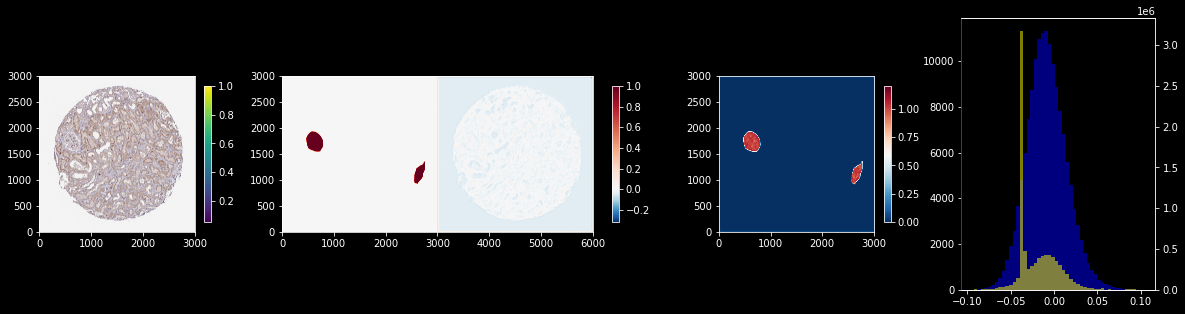

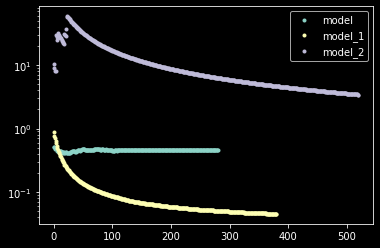

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


In [ ]:
i = 0;

vis = visualizer(model_name=ca.name)
next(vis)

err_fig = plt.figure()
err_ax = err_fig.add_subplot(label="Loss")

for i in range(1000+1):

    batch = data_iter.get_next()
    source, target = split_data_to_x_y(batch)
    metrics = ca.train_step((source.repack()[0], target))
    
    ca_metrics.setdefault(ca.name, appenDict()).update(metrics)
    with writer.as_default():
        for mkey, mval in metrics.items():
            tf.summary.scalar(mkey, mval, step=optimizer.iterations.numpy())
        

    if i % 10 == 0:

        # Evaluate the model on (source, target) returning (loss, cell_loss, yhat)
        yhat = ca(source.repack()[0])
        cell_mse = tf.math.squared_difference(yhat, target)
        loss = ca_metrics[ca.name]["loss"][-1]

        clear_output(wait=True)

        err_ax.clear()
        for run_name, run_metrics in ca_metrics.items():
            err_ax.plot(run_metrics["loss"], '.', label=run_name, alpha=1)
        err_ax.set_yscale('log')
        err_ax.legend()

        batch["yhat"] = yhat
        batch["cell_mse"] = cell_mse
        display(vis.send(batch))
        display(err_fig)
        print(batch["organ"][0, 0, 0])

# Derivative Testing

In [55]:
x0 = data_iter.get_next()
source, target = split_data_to_x_y(x0)
x, _ = source.repack()
x_first = x[0:1]
print(x_first.shape)
center_slice = np.s_[:, target.shape[1]//2, target.shape[2]//2, :]
with tf.GradientTape() as g:
    g.watch(x_first)
    yhat = ca(x_first)
    yhat_central = yhat[center_slice]
    dyc_dx = g.gradient(yhat_central, x_first)

dyc_dx.shape


    


(1, 3000, 3000, 8)


TensorShape([1, 3000, 3000, 8])

In [56]:
norm_dyc_dx = tf.reduce_sum(tf.math.abs(dyc_dx), axis=-1)[0]


In [57]:
print(tf.reduce_mean(norm_dyc_dx))

non_zero = tf.sparse.from_dense(norm_dyc_dx)
sum_non_zero = tf.sparse.reduce_sum(non_zero)
count_non_zero = non_zero.values.shape[0]
print(sum_non_zero / count_non_zero)

tf.Tensor(2.9116366e-06, shape=(), dtype=float32)
tf.Tensor(3.7494454e-05, shape=(), dtype=float32)


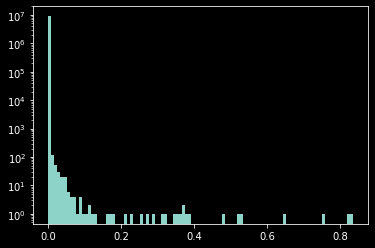

In [58]:
_ = plt.hist(tf.reshape(norm_dyc_dx, [-1]), bins=100, log=True)

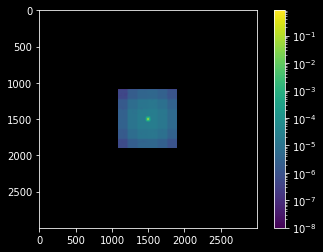

In [59]:
plt.imshow(norm_dyc_dx, norm=colors.LogNorm())
plt.colorbar()

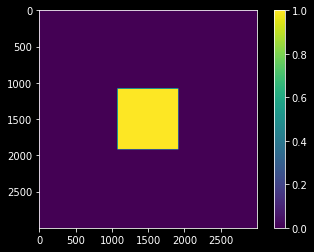

In [60]:
plt.imshow(norm_dyc_dx != 0)
plt.colorbar()